# Group 21 Member: Robin, Fang Chong, Wenjing, Jing Chun, Sheng Yang

## **Problem Statement:** Singapore has a low recycling rate and items that are thrown into the blue recycling bin are only recyclable 50% of the time. The rubbish has to go to recycling sorting facilities and pass through conveyor belt lines and be physically sorted.

Source: https://www.channelnewsasia.com/singapore/in-focus-singapore-recycling-sustainability-blue-bins-waste-1339091

To tackle this. we consider image classification in recycling for blue bins by using some sort of image recognition capacity to allow user to ask if the item is recyclable and or what bins should the object be disposed in.

Kaggle Dataset:
https://www.kaggle.com/datasets/pengrin/recyclability
https://www.kaggle.com/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects
________________________________________________________________________
Methods:
SVM

In [ ]:
!pip install --upgrade kagglehub
!pip install --upgrade imbalanced-learn


import kagglehub

# Download latest version
path = kagglehub.dataset_download("pengrin/recyclability")
path2 = kagglehub.dataset_download("ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects")

print("Path to dataset files:")
print("Recyclability-dataset", path)
print("2nd recyclability dataset", path2)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 3.3 MB/s eta 0:00:00


100%|██████████| 3.31G/3.31G [00:24<00:00, 147MB/s]

Extracting files...


100%|██████████| 66.7M/66.7M [00:00<00:00, 105MB/s] 

Extracting files...


Path to dataset files:
Recyclability-dataset /root/.cache/kagglehub/datasets/pengrin/recyclability/versions/3
2nd recyclability dataset /root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2


In [ ]:
#import all modules neccessarily for image classification
import joblib
import random
from joblib import Parallel, delayed
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from skimage.feature import local_binary_pattern, hog
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV, validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, auc
from sklearn.decomposition import PCA
from skimage import exposure
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from PIL import Image
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from tqdm import tqdm
from IPython.display import YouTubeVideo
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('All modules have been imported')

All modules have been imported


# **Waste Segregation Image Set**

---



In [ ]:
  # Define root directories (pointing to final_dataset folders)
base_dirs = [
    "/root/.cache/kagglehub/datasets/pengrin/recyclability/versions/3/dataset/non_recyclable/final_dataset",
    "/root/.cache/kagglehub/datasets/pengrin/recyclability/versions/3/dataset/recyclable/final_dataset",
    "/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/BOTTLE",
    "/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/CAN",
    "/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/JUICE_BOX",
    "/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/MILK_CARTON",
    "/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/STYROFOAM",
    "/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/UTENSIL"
]


bad_img_list = []

# Loop through the base directories and check files in final_dataset
for base_dir in base_dirs:
    for f in os.listdir(base_dir):  # List files in final_dataset (no subfolders)
        fpath = os.path.join(base_dir, f)
        try:
            img = plt.imread(fpath)  # Try loading the image
        except:
            print(f"Removing corrupted image: {fpath}")
            bad_img_list.append(fpath)
            os.remove(fpath)  # Delete the corrupted image

print(f"Removed {len(bad_img_list)} corrupted images.")


Removing corrupted image: /root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/BOTTLE/BOTTLE (158).xml
Removing corrupted image: /root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/BOTTLE/BOTTLE (503).xml
Removing corrupted image: /root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/BOTTLE/BOTTLE (277).xml
Removing corrupted image: /root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/BOTTLE/BOTTLE (81).xml
Removing corrupted image: /root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/BOTTLE/BOTTLE (295).xml
Removing corrupted image: /root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main D

A function to check for corrupted images.

In [ ]:
def is_valid_image(image_path):
    """
    Check if an image file is valid and not truncated (corrupted).

    Parameters:
        image_path (str): Path to the image file.

    Returns:
        bool: True if valid, False otherwise.
    """
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verify image integrity
        return True
    except Exception as e:
        print(f"Invalid image {image_path}: {e}")
        return False

Only run the below cell block once per runtime due to the movement of images in the final_dataset folders to the train/test folders using shutil.move()

In [ ]:
# Define source directories for Pengrin and AshwinShrivastav datasets
pengrin_recyclable_dir = '/root/.cache/kagglehub/datasets/pengrin/recyclability/versions/3/dataset/recyclable/final_dataset'
pengrin_non_recyclable_dir = '/root/.cache/kagglehub/datasets/pengrin/recyclability/versions/3/dataset/non_recyclable/final_dataset'

ashwinshrivastav_recyclable_dirs = [
    '/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/BOTTLE',
    '/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/CAN'
]

ashwinshrivastav_non_recyclable_dirs = [
    '/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/JUICE_BOX',
    '/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/MILK_CARTON',
    '/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/STYROFOAM',
    '/root/.cache/kagglehub/datasets/ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects/versions/2/Main Dataset/UTENSIL'
]

# Define destination directories for train/test splits
train_recyclable = '/root/.cache/kagglehub/datasets/reorganized/train/recyclable'
train_non_recyclable = '/root/.cache/kagglehub/datasets/reorganized/train/non_recyclable'
test_recyclable = '/root/.cache/kagglehub/datasets/reorganized/test/recyclable'
test_non_recyclable = '/root/.cache/kagglehub/datasets/reorganized/test/non_recyclable'

# Create necessary directories
os.makedirs(train_recyclable, exist_ok=True)
os.makedirs(train_non_recyclable, exist_ok=True)
os.makedirs(test_recyclable, exist_ok=True)
os.makedirs(test_non_recyclable, exist_ok=True)

# Helper function to move files into train/test splits
def split_and_move_images(source_dir, train_dir, test_dir, target_count=None):
    """
    Split images into train and test directories, ensuring an even distribution.

    Parameters:
    - source_dir: Directory of source images
    - train_dir: Destination directory for training images
    - test_dir: Destination directory for test images
    - target_count: If provided, limits the number of images to this count for balancing purposes
    """
    # Define allowed image extensions
    valid_extensions = ['.jpg', '.jpeg', '.png']

    # Get list of image files with valid extensions
    images = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f)) and
              any(f.lower().endswith(ext) for ext in valid_extensions)]

    if len(images) == 0:
        print(f"No images found in {source_dir}. Skipping split for this directory.")
        return

    # If target_count is provided, limit the number of images for balancing
    if target_count is not None:
        # Ensure that target_count is not larger than the number of available images
        target_count = min(target_count, len(images))
        images = random.sample(images, target_count)

    # Split into train and test (80% train, 20% test)
    train_files, test_files = train_test_split(images, test_size=0.2, random_state=42)

    # Move the images to the appropriate directories
    for file in train_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(train_dir, file))
    for file in test_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(test_dir, file))

# Get the number of images in the recyclable directories (Pengrin and AshwinShrivastav)
pengrin_recyclable_images = [f for f in os.listdir(pengrin_recyclable_dir)
                             if os.path.isfile(os.path.join(pengrin_recyclable_dir, f)) and
                             any(f.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png'])]

ashwinshrivastav_recyclable_images = []
for dir in ashwinshrivastav_recyclable_dirs:
    ashwinshrivastav_recyclable_images.extend([f for f in os.listdir(dir)
                                               if os.path.isfile(os.path.join(dir, f)) and
                                               any(f.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png'])])

# Combine the recyclable images from both datasets
all_recyclable_images = pengrin_recyclable_images + ashwinshrivastav_recyclable_images

# Get the number of recyclable images
num_recyclable = len(all_recyclable_images)

# Get the number of images in the non-recyclable directories (Pengrin and AshwinShrivastav)
pengrin_non_recyclable_images = [f for f in os.listdir(pengrin_non_recyclable_dir)
                                 if os.path.isfile(os.path.join(pengrin_non_recyclable_dir, f)) and
                                 any(f.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png'])]

ashwinshrivastav_non_recyclable_images = []
for dir in ashwinshrivastav_non_recyclable_dirs:
    ashwinshrivastav_non_recyclable_images.extend([f for f in os.listdir(dir)
                                                  if os.path.isfile(os.path.join(dir, f)) and
                                                  any(f.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png'])])

# Combine the non-recyclable images from both datasets
all_non_recyclable_images = pengrin_non_recyclable_images + ashwinshrivastav_non_recyclable_images

# Get the number of non-recyclable images
num_non_recyclable = len(all_non_recyclable_images)

# Set the target size for recyclable images to be 1.3 times the size of non-recyclable
target_recyclable_count = int(num_non_recyclable * 1.3)

# Split and move images for recyclable (with target count for balancing) and non-recyclable
split_and_move_images(pengrin_recyclable_dir, train_recyclable, test_recyclable, target_count=target_recyclable_count)
split_and_move_images(ashwinshrivastav_recyclable_dirs[0], train_recyclable, test_recyclable, target_count=target_recyclable_count)
split_and_move_images(ashwinshrivastav_recyclable_dirs[1], train_recyclable, test_recyclable, target_count=target_recyclable_count)

split_and_move_images(pengrin_non_recyclable_dir, train_non_recyclable, test_non_recyclable)
for dir in ashwinshrivastav_non_recyclable_dirs:
    split_and_move_images(dir, train_non_recyclable, test_non_recyclable)

print("Dataset reorganized with reduced imbalance successfully!")


Dataset reorganized with reduced imbalance successfully!


In [ ]:
def verify_split(train_dir, test_dir):
    """
    Verifies the 80-20 split of files between train and test directories.

    Parameters:
        train_dir (str): Path to the training directory.
        test_dir (str): Path to the test directory.
    """
    # Count files in train and test directories
    train_files = sum([len(files) for _, _, files in os.walk(train_dir)])
    test_files = sum([len(files) for _, _, files in os.walk(test_dir)])

    # Calculate percentages
    total_files = train_files + test_files
    train_percentage = (train_files / total_files) * 100 if total_files > 0 else 0
    test_percentage = (test_files / total_files) * 100 if total_files > 0 else 0

    # Print results
    print(f"Train directory: {train_dir}, Files: {train_files}, Percentage: {train_percentage:.2f}%")
    print(f"test directory: {test_dir}, Files: {test_files}, Percentage: {test_percentage:.2f}%")
    print(f"Total files: {total_files}")
    print("\nSplit verified successfully" if 79.5 <= train_percentage <= 80.5 else "\nSplit verification failed")

# Verify for recyclable and non-recyclable categories
verify_split(train_recyclable, test_recyclable)
verify_split(train_non_recyclable, test_non_recyclable)

Train directory: /root/.cache/kagglehub/datasets/reorganized/train/recyclable, Files: 1870, Percentage: 79.98%
test directory: /root/.cache/kagglehub/datasets/reorganized/test/recyclable, Files: 468, Percentage: 20.02%
Total files: 2338

Split verified successfully
Train directory: /root/.cache/kagglehub/datasets/reorganized/train/non_recyclable, Files: 1482, Percentage: 79.89%
test directory: /root/.cache/kagglehub/datasets/reorganized/test/non_recyclable, Files: 373, Percentage: 20.11%
Total files: 1855

Split verified successfully


Since recyclable is roughly 1.86x larger than non_recyclable, we should balance the dataset in the SVM model.  To address the imbalancing use SmoteTomek (Synthetic Minority Over-sampling Technique) and Tomek Links. SMOTE generates synthetic samples for the minority class.
Tomek Links removes some majority class examples that are close to the minority class samples.
The result is a cleaner, more balanced dataset that makes it easier for your model to learn meaningful patterns.

In [ ]:
# -----------------------------
# 1) Optimized Feature Extraction with Parallel Processing
# -----------------------------
def extract_features_parallel(filepath, label, image_size=(128, 128)):
    try:
        # Read and resize image in grayscale
        img_gray = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if img_gray is None:
            return None  # Skip if image can't be read
        img_gray = cv2.resize(img_gray, image_size)

        # 1. Grayscale Histogram (256 bins)
        hist = cv2.calcHist([img_gray], [0], None, [256], [0, 256]).flatten()

        # 2. Local Binary Pattern (LBP)
        lbp = local_binary_pattern(img_gray, 8, 1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=10, range=(0, 10), density=True)

        # 3. Histogram of Oriented Gradients (HOG)
        hog_features = hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)

        # Combine all features into one vector
        combined_features = np.concatenate((hist, lbp_hist, hog_features))
        return (combined_features, label)

    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

# -----------------------------
# 2) Data Loading
# -----------------------------
train_dir = "/root/.cache/kagglehub/datasets/reorganized/train"
test_dir = "/root/.cache/kagglehub/datasets/reorganized/test"

train_data = []
test_data = []

for label in ['recyclable', 'non_recyclable']:
    label_dir_train = os.path.join(train_dir, label)
    label_dir_test = os.path.join(test_dir, label)

    train_data.extend([(os.path.join(label_dir_train, img), label)
                       for img in os.listdir(label_dir_train) if img.endswith(('.jpg', '.png', '.jpeg'))])
    test_data.extend([(os.path.join(label_dir_test, img), label)
                      for img in os.listdir(label_dir_test) if img.endswith(('.jpg', '.png', '.jpeg'))])

# Convert to DataFrame
train_df = pd.DataFrame(train_data, columns=["filepaths", "labels"])
test_df = pd.DataFrame(test_data, columns=["filepaths", "labels"])

# -----------------------------
# 3) Extract Features in Parallel
# -----------------------------
print("Extracting training features...")
train_results = Parallel(n_jobs=-1)(delayed(extract_features_parallel)(row['filepaths'], row['labels']) for _, row in train_df.iterrows())
train_results = [r for r in train_results if r is not None]  # Remove failed cases
train_features, train_labels = zip(*train_results)

print("Extracting test features...")
test_results = Parallel(n_jobs=-1)(delayed(extract_features_parallel)(row['filepaths'], row['labels']) for _, row in test_df.iterrows())
test_results = [r for r in test_results if r is not None]  # Remove failed cases
test_features, test_labels = zip(*test_results)

# Convert to NumPy arrays
train_features, train_labels = np.array(train_features), np.array(train_labels)
test_features, test_labels = np.array(test_features), np.array(test_labels)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class {i}: {class_name}")

Extracting training features...
Extracting test features...
Class 0: non_recyclable
Class 1: recyclable


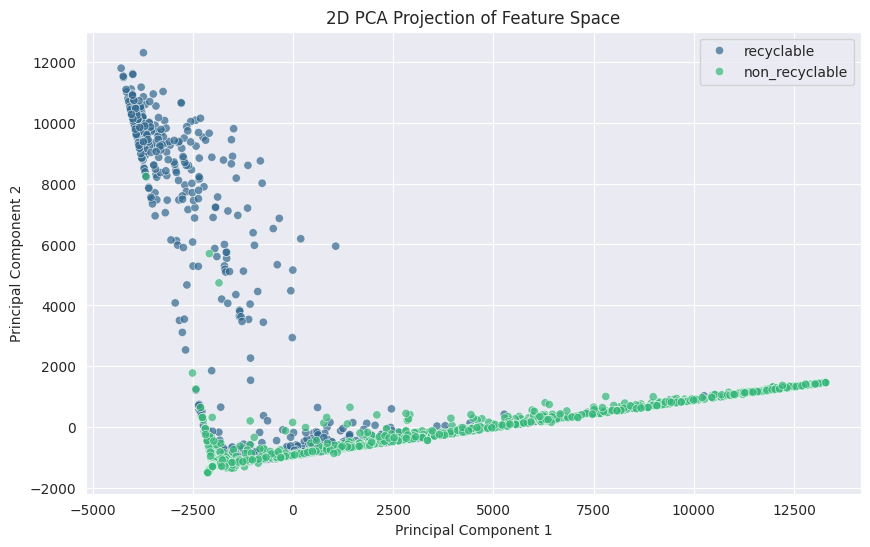

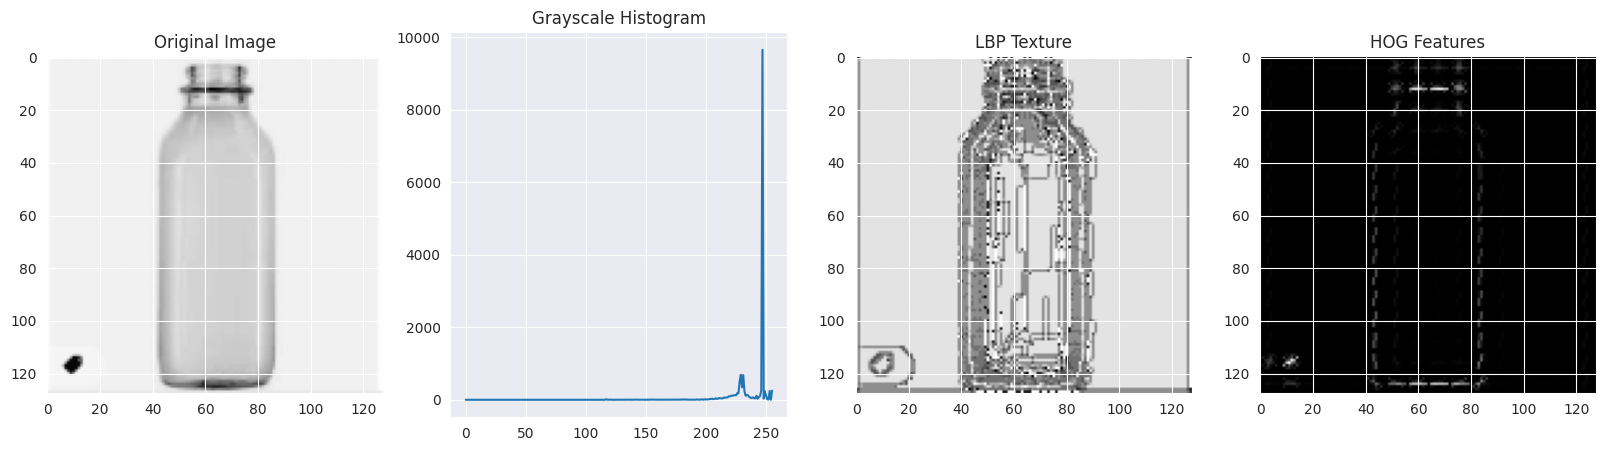

In [ ]:
# -----------------------------
# 3.5) visualizing images and feature space
# -----------------------------

def visualize_feature_space(features, labels):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_features[:,0], y=reduced_features[:,1],
                    hue=labels, palette='viridis', alpha=0.7)
    plt.title('2D PCA Projection of Feature Space')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

def visualize_extracted_features(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    # Calculate features
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    lbp = local_binary_pattern(img, 8, 1, method="uniform")
    hog_features, hog_img = hog(img, orientations=9, pixels_per_cell=(8,8),
                              cells_per_block=(2,2), block_norm='L2-Hys',
                              visualize=True)

    # Plot
    fig, ax = plt.subplots(1, 4, figsize=(20,5))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image')

    ax[1].plot(hist)
    ax[1].set_title('Grayscale Histogram')

    ax[2].imshow(lbp, cmap='gray')
    ax[2].set_title('LBP Texture')

    ax[3].imshow(hog_img, cmap='gray')
    ax[3].set_title('HOG Features')

    plt.show()



visualize_feature_space(train_features, train_labels)

sample_image = train_df.iloc[3]['filepaths']
visualize_extracted_features(sample_image)

From the PCA projection of Feature Space graph, the recyclable and non_recyclable classes tend to form 2 distinct clusters, but there is overlap around (0, -1000). The graph also indicates that the data is not linearly separable.

In [ ]:
# -----------------------------
# 4) Handle Class Imbalance (ADASYN)
# -----------------------------
print("Applying Adaptive Synthetic Sampling for class balancing")

adasyn = ADASYN(random_state=42, sampling_strategy='auto', n_neighbors=5)
train_features, train_labels_encoded = adasyn.fit_resample(train_features, train_labels_encoded)

Applying Adaptive Synthetic Sampling for class balancing


this may take awhile...

Explained variance ratio: [0.52926342 0.26590323 0.03403986 0.02699613 0.01489712 0.01141407
 0.00944721 0.00735721 0.00635061 0.00610924 0.005421   0.00484776
 0.00450667 0.00435175 0.00383267 0.0037546  0.0031984  0.00311176
 0.0028582  0.00274575]


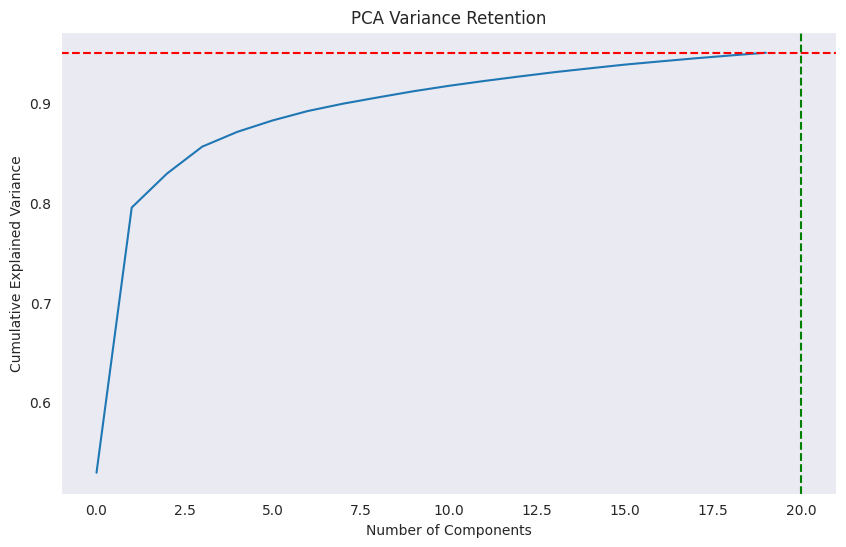

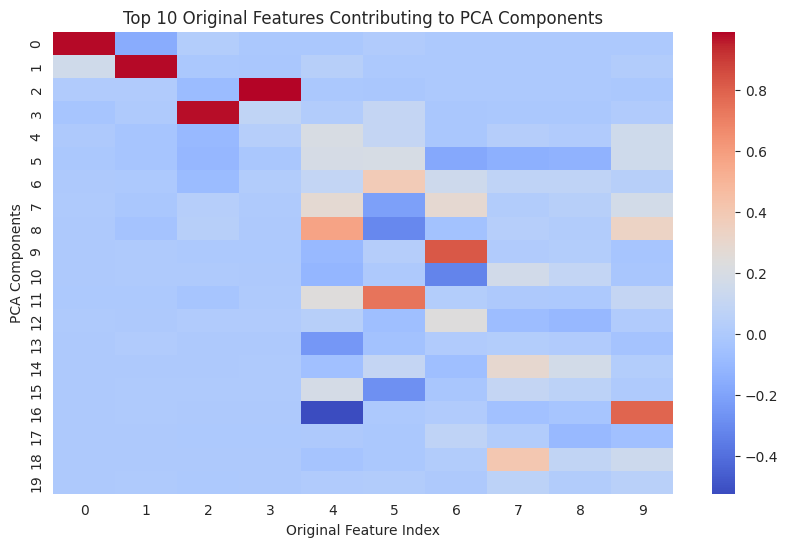

In [ ]:
# -----------------------------
# 5) Feature Selection with PCA
# -----------------------------
pca = PCA(n_components=0.95)  # Keep 95% variance
train_features = pca.fit_transform(train_features)
test_features = pca.transform(test_features)
print("Explained variance ratio:", pca.explained_variance_ratio_)

def plot_pca_variance(pca):
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Variance Retention')
    plt.axhline(y=0.95, color='r', linestyle='--')
    plt.axvline(x=pca.n_components_, color='g', linestyle='--')
    plt.grid()
    plt.show()

def plot_component_heatmap(pca, n_features=10):
    # Get most important features for first component
    most_important = np.abs(pca.components_[0]).argsort()[::-1][:n_features]

    plt.figure(figsize=(10, 6))
    sns.heatmap(pca.components_[:, most_important], cmap='coolwarm')
    plt.title(f'Top {n_features} Original Features Contributing to PCA Components')
    plt.xlabel('Original Feature Index')
    plt.ylabel('PCA Components')
    plt.show()


plot_pca_variance(pca)
plot_component_heatmap(pca)

The red and blue color intensities represent how much each original feature contributes to a PCA component.
Red = Strong positive contribution.
Blue = Strong negative contribution.
Lighter colors = Weaker influence.

In [ ]:
# -----------------------------
# 6) Hyperparameter Tuning with RandomizedSearchCV
# -----------------------------
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_encoded), y=train_labels_encoded)
class_weight = {0: class_weights[0] * 2, 1: class_weights[1]}
pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, class_weight=class_weight, random_state=42))

param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1, 10],
    'svc__kernel': ['linear', 'sigmoid', 'poly', 'rbf'],  # Test different kernels
    'svc__degree': [3, 4],  # Polynomial kernel degrees (only used if kernel is 'poly')
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    scoring='recall',  # Optimize recall to minimize false negatives
    n_iter=12,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

grid_search.fit(train_features, train_labels_encoded)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc',
                                              SVC(class_weight={0: 2.0898483080513417,
                                                                1: 0.958779443254818},
                                                  probability=True,
                                                  random_state=42))]),
                   n_iter=12, n_jobs=-1,
                   param_distributions={'svc__C': [0.1, 1, 10, 100],
                                        'svc__degree': [3, 4],
                                        'svc__gamma': [0.001, 0.01, 0.1, 1, 10],
                                        'svc__kernel': ['linear', 'sigmoid',
                                                        'poly', 'rbf']},
                   random_state=42, scoring='recall', verbose=1)

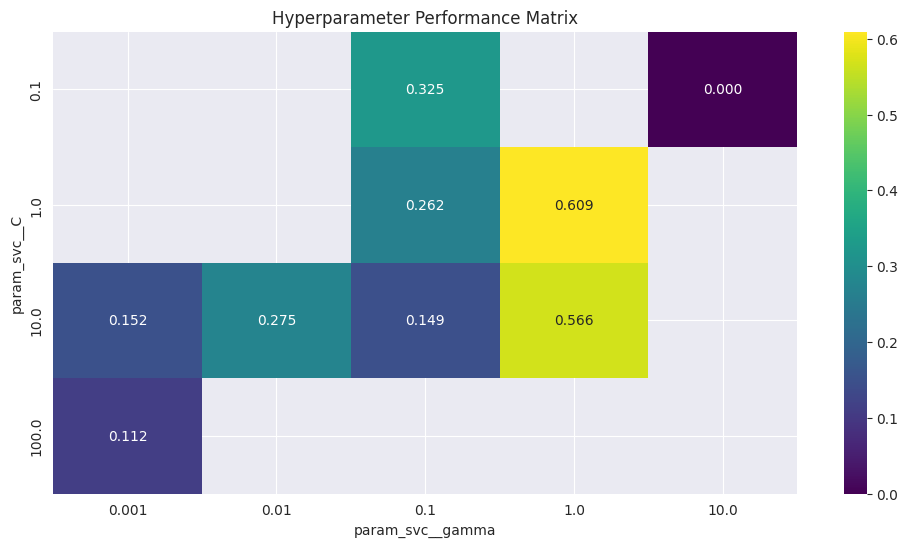

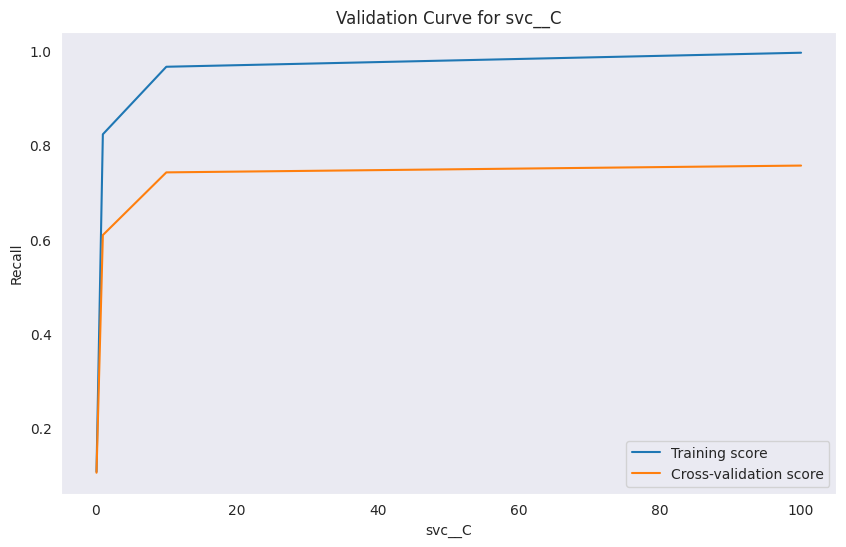

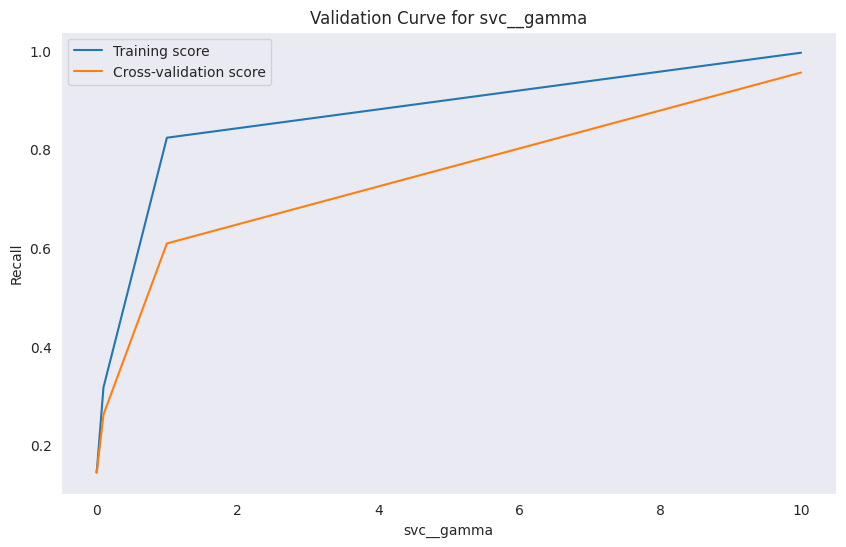

In [ ]:
# -----------------------------
# 6.5) Hyperparameter combination visualization
# -----------------------------

def plot_parameter_performance(grid_search):
    cv_results = pd.DataFrame(grid_search.cv_results_)
    plt.figure(figsize=(12, 6))
    sns.heatmap(pd.pivot_table(cv_results, values='mean_test_score',
                              index='param_svc__C',
                              columns='param_svc__gamma'),
                annot=True, fmt=".3f", cmap='viridis')
    plt.title('Hyperparameter Performance Matrix')
    plt.show()

def plot_validation_curve(param_name, param_range):
    train_scores, test_scores = validation_curve(
        grid_search.best_estimator_,
        train_features,
        train_labels_encoded,
        param_name=param_name,
        param_range=param_range,
        cv=cv,
        scoring="recall",
        n_jobs=-1
    )

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-validation score')
    plt.xlabel(param_name)
    plt.ylabel('Recall')
    plt.title(f'Validation Curve for {param_name}')
    plt.legend()
    plt.grid()
    plt.show()

plot_parameter_performance(grid_search)
plot_validation_curve('svc__C', [0.1, 1, 10, 100])
plot_validation_curve('svc__gamma', [0.001, 0.01, 0.1, 1, 10])

In [ ]:
# -----------------------------
# 7) Cross-Validation on Final Model
# -----------------------------
best_pipeline = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Perform 5-fold cross-validation on the final model
cv_scores = cross_val_score(
    best_pipeline,
    train_features,
    train_labels_encoded,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='recall',
    n_jobs=-1
)

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


Best parameters: {'svc__kernel': 'rbf', 'svc__gamma': 1, 'svc__degree': 3, 'svc__C': 1}
Cross-Validation Accuracy Scores: [0.63101604 0.63636364 0.61764706 0.57640751 0.5844504 ]
Mean CV Accuracy: 0.6091769293630198


Test Accuracy: 0.6626936829558999
Classification Report:
                precision    recall  f1-score   support

non_recyclable       0.61      0.68      0.64       372
    recyclable       0.72      0.65      0.68       467

      accuracy                           0.66       839
     macro avg       0.66      0.66      0.66       839
  weighted avg       0.67      0.66      0.66       839



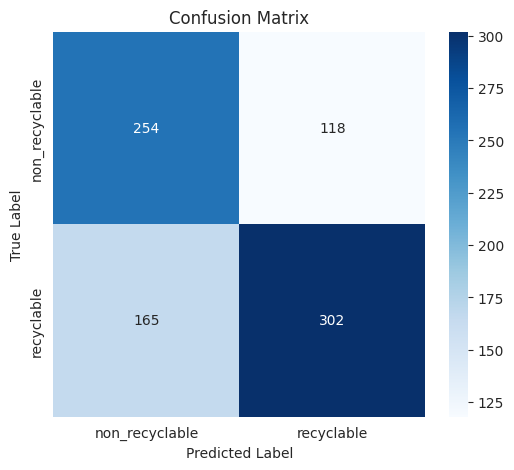

Optimized SVM model saved successfully!


In [ ]:
# -----------------------------
# 8) Train Final Model on Full Training Set
# -----------------------------
best_pipeline.fit(train_features, train_labels_encoded)

# -----------------------------
# 9) Evaluate on Test Set
# -----------------------------
test_predictions = best_pipeline.predict(test_features)

# Print classification report
print("Test Accuracy:", accuracy_score(test_labels_encoded, test_predictions))
print("Classification Report:")
print(classification_report(test_labels_encoded, test_predictions, target_names=label_encoder.classes_))

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, test_predictions)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# -----------------------------
# 10) Save the Model
# -----------------------------
joblib.dump(best_pipeline, "optimized_svm_recycling.pkl")
print("Optimized SVM model saved successfully!")

SMOTE, SmoteTomek and ADASYN techniques were tested to see which addresses the class imbalance better.









0.7548294996661371


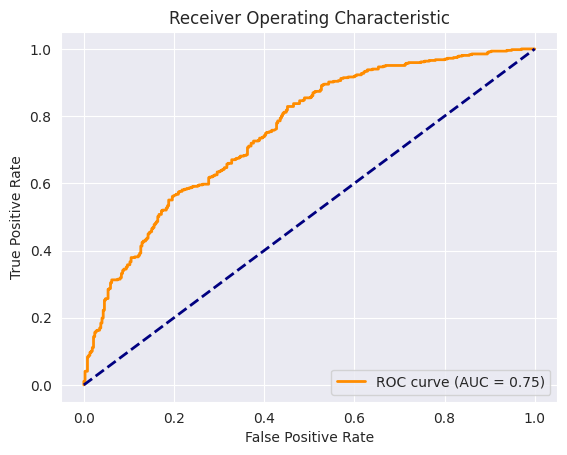

In [ ]:
y_scores = best_pipeline.predict_proba(test_features)[:, 1]
fpr, tpr, _ = roc_curve(test_labels_encoded, y_scores)
roc_auc = auc(fpr, tpr)

print(roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

After  testing,
Hyperparameter Tuning Results with
param_grid = {
    'svc__C': [0.1, 1, 10, 50, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1, 10],
    'svc__kernel': ['linear', 'sigmoid', 'poly', 'rbf'],  # Test different kernels
    'svc__degree': [3, 4],  # Polynomial kernel degrees (only used if kernel is 'poly')
}

(we tested much more than this)
Best parameters: {'svc__kernel': 'rbf', 'svc__gamma': 1, 'svc__degree': 3, 'svc__C': 10}



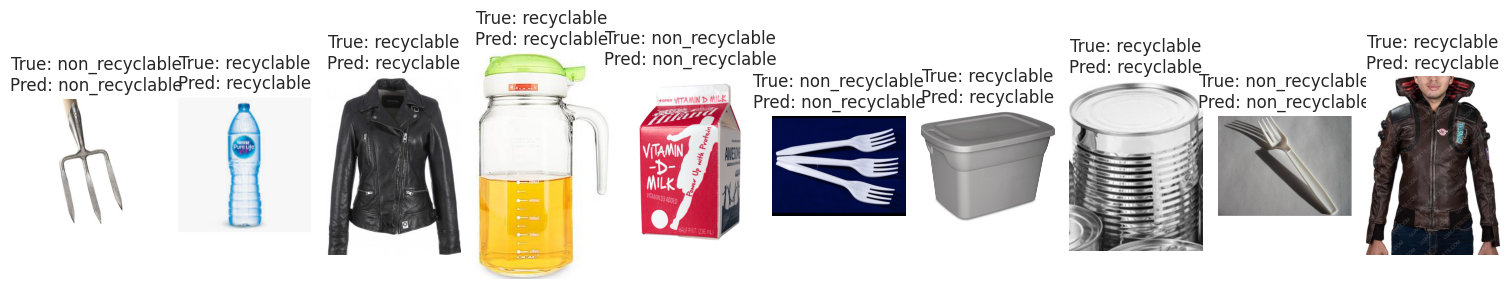

In [ ]:
# Load the saved model
best_pipeline = joblib.load("optimized_svm_recycling.pkl")

# Use the loaded model to make predictions
test_predictions = best_pipeline.predict(test_features)

# Function to display a random batch of images with predicted and true labels
def display_random_batch(test_df, test_labels, test_predictions, label_encoder, batch_size=5):
    # Select random indices from the test data
    random_indices = np.random.choice(len(test_df), size=batch_size, replace=False)

    # Create a figure for displaying images
    fig, axes = plt.subplots(1, batch_size, figsize=(15, 10))

    for i, idx in enumerate(random_indices):
        # Get the image file path
        img_path = test_df.iloc[idx]['filepaths']

        # Load the image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        # Get true and predicted labels
        true_label = test_labels[idx]
        predicted_label = test_predictions[idx]

        # Convert encoded labels back to class names
        true_class = label_encoder.inverse_transform([true_label])[0]
        predicted_class = label_encoder.inverse_transform([predicted_label])[0]

        # Display the image with labels
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_class}\nPred: {predicted_class}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display a random batch of images
display_random_batch(test_df, test_labels_encoded, test_predictions, label_encoder, batch_size=10)
